In [1]:
import argparse
import os
import os.path as osp
import shutil
import time
import warnings
from mmcv.image import tensor2imgs
import mmcv
import torch
from mmcv.cnn.utils import revert_sync_batchnorm
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import (get_dist_info, init_dist, load_checkpoint,
                         wrap_fp16_model)
from mmcv.utils import DictAction
from mmseg.datasets import build_dataloader, build_dataset
from mmseg.models import build_segmentor
from mmseg.utils import setup_multi_processes
from mmseg.ops import resize
import torch.nn.functional as F
import cv2
import numpy as np
import einops
config="configs/segdiffusion/upernet_beit-base_512x512_160k_ade20k_20t_kl_loss.py"
checkpoint="pretrain/seg_diff_20t_160k.pth"
sample_bias=10
gpu_ids=[0]
cfg = mmcv.Config.fromfile(config)
dataset = build_dataset(cfg.data.test)
inference_with_uc=True
def mod_log_z_by_uc(log_z,uc,t):
    rate=1.0/20.0/19.0*t
    gate=torch.quantile(uc, 1-rate)
    to_mask=uc>gate
    mask=torch.zeros_like(log_z)
    mask[:,-1]=1
    mask = torch.log(mask.clamp(min=1e-30))
    p=to_mask*mask+(~to_mask)*log_z
    log_z.data.copy_(p)

def extract_uc(logits_aux):
    #print(logits_aux.sum(dim=1))
    x=einops.repeat(-torch.log(logits_aux),"B C H W -> B C 9 H W")
    B,C,_,H,W=x.shape
    logits_aux=F.pad(logits_aux,(1,1,1,1),"reflect")
    logits_aux=F.unfold(logits_aux,3,stride=1)
    logits_aux=einops.rearrange(logits_aux,"B (c t1 t2) (H W) -> B c (t1 t2) H W",t1=3,t2=3,H=H,W=W)
    uc_map=torch.einsum("abcde,abcde->ade",x,logits_aux)/9
    return uc_map.unsqueeze(1)

loader_cfg = dict(
    # cfg.gpus will be ignored if distributed
    num_gpus=1,
    dist=False)
# The overall dataloader settings
loader_cfg.update({
    k: v
    for k, v in cfg.data.items() if k not in [
        'train', 'val', 'test', 'train_dataloader', 'val_dataloader',
        'test_dataloader'
    ]
})
test_loader_cfg = {
    **loader_cfg,
    'samples_per_gpu': len(gpu_ids),
    'shuffle': False,  # Not shuffle by default
    **cfg.data.get('test_dataloader', {})
}
# build the dataloader
data_loader = build_dataloader(dataset, **test_loader_cfg)
model = build_segmentor(cfg.model, test_cfg=cfg.get('test_cfg'))
checkpoint = load_checkpoint(model, checkpoint, map_location='cpu')
if 'CLASSES' in checkpoint.get('meta', {}):
    model.CLASSES = checkpoint['meta']['CLASSES']
else:
    print('"CLASSES" not found in meta, use dataset.CLASSES instead')
    model.CLASSES = dataset.CLASSES
if 'PALETTE' in checkpoint.get('meta', {}):
    model.PALETTE = checkpoint['meta']['PALETTE']
else:
    print('"PALETTE" not found in meta, use dataset.PALETTE instead')
    model.PALETTE = dataset.PALETTE
torch.cuda.empty_cache()
model = revert_sync_batchnorm(model)
#model = MMDataParallel(model, device_ids=gpu_ids)
model=model.cuda()

def make_grid(imgs,rows=0,margin=5):
    H,W,C=imgs[0].shape
    li=len(imgs)
    if not rows:
        rows=int(np.floor(np.sqrt(li)))
    cols=int(np.ceil(li/rows))
    pad=np.zeros(((H+margin)*rows-margin,(W+margin)*cols-margin,3),dtype=np.uint8)
    for  i in range(li):
        rs=i//cols
        ls=i%cols
        pad[rs*(H+margin):rs*(H+margin)+H,ls*(W+margin):ls*(W+margin)+W]=imgs[i]
    return pad

def vis_uc(x,color):
    color=np.array(color).reshape(1,1,3)
    x=x/np.max(x)
    return np.expand_dims(x,-1)*color
    

def slide_inference(model, img):
    h_stride, w_stride = model.test_cfg.stride
    h_crop, w_crop = model.test_cfg.crop_size
    batch_size, _, h_img, w_img = img.size()
    num_classes = model.num_classes
    h_grids = max(h_img - h_crop + h_stride - 1, 0) // h_stride + 1
    w_grids = max(w_img - w_crop + w_stride - 1, 0) // w_stride + 1
    crop_images=[]
    for h_idx in range(h_grids):
        for w_idx in range(w_grids):
            y1 = h_idx * h_stride
            x1 = w_idx * w_stride
            y2 = min(y1 + h_crop, h_img)
            x2 = min(x1 + w_crop, w_img)
            y1 = max(y2 - h_crop, 0)
            x1 = max(x2 - w_crop, 0)
            crop_img = img[:, :, y1:y2, x1:x2]
            crop_images.append(crop_img)
    def merge_fn(patches):
        preds = torch.zeros((batch_size, num_classes+1, h_img, w_img),device=patches[0].device)
        count_mat = torch.zeros((batch_size, 1, h_img, w_img),device=patches[0].device)
        i=0
        for h_idx in range(h_grids):
            for w_idx in range(w_grids):
                y1 = h_idx * h_stride
                x1 = w_idx * w_stride
                y2 = min(y1 + h_crop, h_img)
                x2 = min(x1 + w_crop, w_img)
                y1 = max(y2 - h_crop, 0)
                x1 = max(x2 - w_crop, 0)
                crop_seg_logit = patches[i]
                B,C,H,W=crop_seg_logit.shape
                i+=1
                preds[:,:C,y1:y2, x1:x2]+=crop_seg_logit
                # preds += F.pad(crop_seg_logit,
                #                 (int(x1), int(preds.shape[3] - x2), int(y1),
                #                 int(preds.shape[2] - y2)))
                count_mat[:, :, y1:y2, x1:x2] += 1
        assert (count_mat == 0).sum() == 0
        preds = preds / count_mat
        return preds
    return crop_images, merge_fn


def single_gpu_test(model,data_loader,out_dir="work_dirs/seg_diff/visualize",opacity=0.5):
    model.eval()
    results = []
    dataset = data_loader.dataset
    prog_bar = mmcv.ProgressBar(len(dataset))
    loader_indices = data_loader.batch_sampler
    counter=0
    os.makedirs(out_dir,exist_ok=True)
    for batch_indices, data in zip(loader_indices, data_loader):
        with torch.no_grad():
            #print(list(data['img_metas']))
            img_tensor = data['img'][0]
            img_metas = data['img_metas'][0].data[0]
            imgs = tensor2imgs(img_tensor, **img_metas[0]['img_norm_cfg'])
            gt=dataset.get_gt_seg_map_by_idx(counter)
            gt=torch.from_numpy(gt).unsqueeze(0).to(dtype=torch.uint8)-1
            assert len(imgs) == len(img_metas)
            crop_images, merge_fn = slide_inference(model, img_tensor.cuda())
            ts=[[] for i in range(len(crop_images))]
            zs=[[] for i in range(len(crop_images))]
            xs=[[] for i in range(len(crop_images))]
            outs=[]
            temp_uc=[0]
            for i in range(len(crop_images)):
                def call_back(log_z,log_x_recon,t,**args):
                    ts[i].append(t[0].item())
                    xs[i].append(resize(input=torch.exp(log_x_recon),size=crop_images[0].shape[2:],mode='bilinear',align_corners=model.align_corners))
                    if inference_with_uc:
                        if ts[i][-1]==19:
                            temp_uc_=extract_uc(xs[i][-1])
                            temp_uc[0]=temp_uc_/temp_uc_.max()
                        mod_log_z_by_uc(log_z,temp_uc[0],ts[i][-1])
                    zs[i].append(resize(input=torch.exp(log_z),size=crop_images[0].shape[2:],mode='bilinear',align_corners=model.align_corners))
                    
                out = model.sample(crop_images[i],return_logits = True,call_back=call_back)
                out = out['logits']
                out = resize(input=out,size=crop_images[0].shape[2:],mode='bilinear',align_corners=model.align_corners)
                outs.append(out)
            out=merge_fn(outs)
            zs=[merge_fn(i) for i in  zip(*zs)]
            xs=[merge_fn(i) for i in  zip(*xs)]
            ts=ts[0]
            img=imgs[0]
            img_meta=img_metas[0]
            h, w, _ = img_meta['img_shape']
            img_show = img[:h, :w, :]
            ori_h, ori_w = img_meta['ori_shape'][:-1]
            uc_map=[resize(extract_uc(i), (ori_h, ori_w),mode='bilinear',align_corners=model.align_corners) for i in xs]
            img_show = mmcv.imresize(img_show, (ori_w, ori_h))
            showed_img_out=model.show_result(img_show,torch.argmax(resize(out, (ori_h, ori_w),mode='bilinear',align_corners=model.align_corners),1).cpu(),opacity=opacity)
            showed_gt=model.show_result(img_show,gt,opacity=opacity)
            xs=[torch.argmax(resize(i, (ori_h, ori_w),mode='bilinear',align_corners=model.align_corners),1).cpu() for i in xs]
            zs=[torch.argmax(resize(i, (ori_h, ori_w),mode='bilinear',align_corners=model.align_corners),1).cpu() for i in zs]
            errs=[(i!=gt) & (gt !=255) for i in xs]
            #print(uc_map[0])
            uc_map=[(vis_uc(i.squeeze().cpu().numpy(),[255,255,255])).astype("uint8") for i in uc_map]
            uc_map=make_grid(uc_map)
            cv2.imwrite("%s/%s_uncertainty.png"%(out_dir,counter),uc_map)
            err_map=[(vis_uc(i.squeeze().cpu().numpy(),[255,255,255])).astype("uint8") for i in errs]
            err_map=make_grid(err_map)
            cv2.imwrite("%s/%s_err.png"%(out_dir,counter),err_map)
            showed_zt_out=make_grid([model.show_result(img_show,i,opacity=opacity) for i in zs])
            showed_xt_out=make_grid([model.show_result(img_show,i,opacity=opacity) for i in xs])
            cv2.imwrite("%s/%s_seg.png"%(out_dir,counter),showed_img_out)
            cv2.imwrite("%s/%s_seg_gt.png"%(out_dir,counter),showed_gt)
            cv2.imwrite("%s/%s_zt.png"%(out_dir,counter),showed_zt_out)
            cv2.imwrite("%s/%s_xt.png"%(out_dir,counter),showed_xt_out)
            counter+=1
            torch.cuda.empty_cache()
        batch_size = len(out)
        for _ in range(batch_size):
            prog_bar.update()


single_gpu_test(model,data_loader)

2022-05-13 04:03:56,898 - mmseg - INFO - Loaded 2000 images
/public/zhaohanqing/anaconda3/envs/py3x/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/ssd/zhaohanqing/msws/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:232: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: pretrain/seg_diff_20t_160k.pth
[                               ] 1/2000, 0.1 task/s, elapsed: 11s, ETA: 22823s

RuntimeError: CUDA out of memory. Tried to allocate 1.82 GiB (GPU 0; 23.70 GiB total capacity; 13.66 GiB already allocated; 1.31 GiB free; 20.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [4]:
for i,j in enumerate(zs[::-1]):
    j=torch.argmax(j,dim=1)
    mask=torch.sum(j==149).item()
    unmask=torch.sum(j!=149).item()
    print("t=",i," mask tokens: ",mask," unmask tokens: ",unmask)

t= 0  mask tokens:  0  mask tokens:  349696
t= 1  mask tokens:  18426  mask tokens:  331270
t= 2  mask tokens:  29325  mask tokens:  320371
t= 3  mask tokens:  41055  mask tokens:  308641
t= 4  mask tokens:  53411  mask tokens:  296285
t= 5  mask tokens:  66723  mask tokens:  282973
t= 6  mask tokens:  80375  mask tokens:  269321
t= 7  mask tokens:  94900  mask tokens:  254796
t= 8  mask tokens:  110119  mask tokens:  239577
t= 9  mask tokens:  126167  mask tokens:  223529
t= 10  mask tokens:  142813  mask tokens:  206883
t= 11  mask tokens:  160051  mask tokens:  189645
t= 12  mask tokens:  178087  mask tokens:  171609
t= 13  mask tokens:  196827  mask tokens:  152869
t= 14  mask tokens:  216690  mask tokens:  133006
t= 15  mask tokens:  237119  mask tokens:  112577
t= 16  mask tokens:  257800  mask tokens:  91896
t= 17  mask tokens:  279769  mask tokens:  69927
t= 18  mask tokens:  302422  mask tokens:  47274
t= 19  mask tokens:  325770  mask tokens:  23926


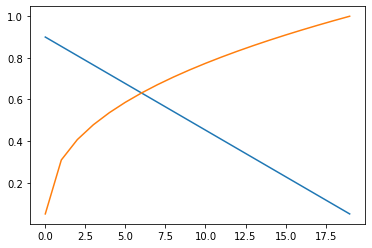

In [16]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
N=20
x=np.arange(20)
ctt_0=0.05
ctt_T=0.99999
snr_0=0.9
snr_T=0.05
r=0.4
ctt=np.linspace(ctt_0**(1/r),ctt_T**(1/r),N)**r
snr=np.linspace(snr_0,snr_T,N)
assert all(ctt<1)
one_minus_ctt = 1 - ctt
att=one_minus_ctt*snr
assert len(ctt)==N
assert len(att)==N
at = att[1:]/att[:-1]
one_minus_ct = one_minus_ctt[1:] / one_minus_ctt[:-1]
ct = 1-one_minus_ct
bt = (1-at-ct)
btt = (1-att-ctt)
assert all(bt>0)
assert all(btt>0)
assert att[0]>=0.8
assert ctt[0]<=0.1
assert ctt[-1]>0.9999
plt.plot(x,snr,label="snr")
plt.plot(x,ctt,label="ctt")
plt.show()
